In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import cv2
from matplotlib import pyplot as plt
from scipy import ndimage
import pickle
import numpy as np
import time
import random
import img as img_lib
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

STROKES = ["straight", "convex", "concave", "squiggle"]
class StrokeClassifier(nn.Module):

    def __init__(self, img_dims=(img_lib.H, img_lib.W)):
        super(StrokeClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, 3),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(4, 8, 3),
            nn.MaxPool2d(3),
            nn.Conv2d(8, 16, 3),
            nn.MaxPool2d(3),
            nn.Conv2d(16, 32, 3),
        )
        dummy = torch.zeros(img_dims).unsqueeze(0)

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(self.features(dummy).shape), 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, len(STROKES)),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        return x


C:\Users\chian\anaconda3\envs\ai4m\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def do_transform_vanilla(img, label, base):
    label = np.array(label)
    diff = img.shape[1] - img.shape[0]
    img = np.pad(img, ((diff//2, diff//2), (0, 0), (0, 0)))
    label[:,0] += diff//2
    center = (img.shape[1]//2, img.shape[0]//2)
    angle = random.randint(-90, 90)
    scale = random.uniform(min(base.shape[:2]) / img.shape[0] * 0.8, min(base.shape[:2]) / img.shape[0] * 1)
    rot_mat = cv2.getRotationMatrix2D( center, angle, scale )
    out = cv2.warpAffine(img, rot_mat, (img.shape[1], img.shape[0]))
    
    # Hacky label translation
    rot_mat = cv2.getRotationMatrix2D( center, angle, 1 )
    inv_rot_mat = np.zeros(rot_mat.shape)
    cv2.invertAffineTransform(rot_mat, inv_rot_mat)
    transform_label = np.zeros(label.shape)
    transform_label[0] = inv_rot_mat[:, :2] @ label[0] + inv_rot_mat[:, 2]
    transform_label[1] = inv_rot_mat[:, :2] @ label[1] + inv_rot_mat[:, 2]
    dir_to_center = np.zeros(transform_label.shape)
    dir_to_center[transform_label > center] = -1
    dir_to_center[transform_label < center] = 1
    transform_label = transform_label + dir_to_center * abs((center - transform_label) * (1-scale))
    
    # crop stroke
    scaled_size = int(scale * out.shape[0])
    crop_h = max(center[0] - scaled_size//2, 0)
    crop_w = max(center[1] - scaled_size//2, 0)
    out = out[crop_h:crop_h + scaled_size,crop_w:crop_w + scaled_size]
    transform_label[:,0] -= crop_h
    transform_label[:,1] -= crop_w
    
    # overlay on base img
    base = cv2.cvtColor(base, cv2.COLOR_RGB2RGBA)
    offset_h = random.randint(0, base.shape[0] - out.shape[0])
    offset_w = random.randint(0, base.shape[1] - out.shape[1])  
    base[offset_h:offset_h+out.shape[0], offset_w:offset_w+out.shape[1]] = np.where(out[:,:,3,None] == 0, base[offset_h:offset_h+out.shape[0], offset_w:offset_w+out.shape[1]], out)
#     plt.imshow(base)

    transform_label[:,0] += offset_h
    transform_label[:,1] += offset_w
    transform_label = transform_label.astype(int)
#     base[transform_label[0][0]:transform_label[0][0] + 4, transform_label[0][1]:transform_label[0][1]+4] = np.array([255,0,0,255])
#     base[transform_label[1][0]:transform_label[1][0] + 4, transform_label[1][1]:transform_label[1][1]+4] = np.array([0,255,0,255])
    return base, transform_label

import copy
def overlay(stroke, base):

    base = cv2.cvtColor(base, cv2.COLOR_RGB2RGBA)
    offset_h = random.randint(0, base.shape[0] - stroke.shape[0])
    offset_w = random.randint(0, base.shape[1] - stroke.shape[1])    
    base[offset_h:offset_h+stroke.shape[0], offset_h:offset_h+stroke.shape[1]] = np.where(stroke[:,:,3,None] == 0, base[offset_h:offset_h+stroke.shape[0], offset_h:offset_h+stroke.shape[1]], stroke)
    
    return base
    

torch.Size([1, 224, 224])

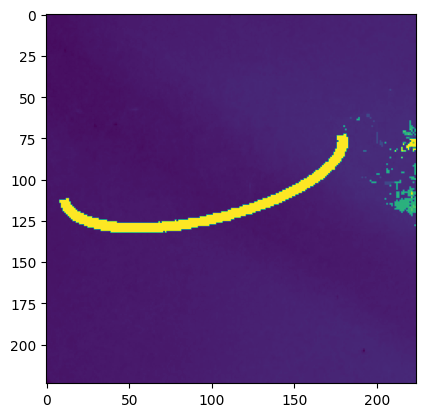

In [3]:
import importlib
importlib.reload(img_lib)
class ImgDataset(Dataset):
    def __init__(self, data_path, strokes, size=(224, 224), augmentation=None, return_coords=False, length=1000):
        with open(data_path, "rb") as f:
            self.data = pickle.load(f)
        self.return_coords = return_coords
        self.augmentation = augmentation
        self.size = size
        self.strokes = strokes
        self.length = length
        self.square_base = cv2.resize(self.data["base"], size)
        
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        crop_h = random.randint(0, self.data["base"].shape[0] - self.size[0])
        crop_w = random.randint(0, self.data["base"].shape[1] - self.size[1])
        base = self.data["base"][crop_h:crop_h+self.size[0], crop_w:crop_w+self.size[1]]
        item = self.data[self.strokes[random.randint(0,len(self.strokes) - 1)]]
        stroke = item["img"]
        img, coord_labels = do_transform_vanilla(stroke, np.array([item["start"],item["end"]]), base)
#         plt.imshow(img)

        img = img[:,:,:3].transpose(2,0,1)
#         plt.imshow(img.transpose(1,2,0))

        img = self.augmentation(torch.Tensor(img)/255) * 255
        
        debug = img.numpy().transpose(1,2,0).astype(np.uint8)
#         plt.imshow(debug)
        debug = cv2.absdiff(debug, self.square_base)
#         plt.imshow(debug)
        
        img = img_lib.remove_bg(img.numpy().transpose(1,2,0).astype(np.uint8), self.square_base)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        return torch.Tensor(img/255).unsqueeze(2).permute(2,0,1), item["label"]
    
    

# plt.imshow(train_ds[0][0].numpy().transpose(1,2,0))
plt.imshow((train_ds[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8))
train_ds[0][0].shape

In [4]:

model = StrokeClassifier(img_dims=(224, 224))
optimizer = optim.AdamW(model.parameters(), lr=0.001)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(8):
    correct = 0
    tot = 0
    for batch in tqdm(train_dl):
        imgs = batch[0]
        labels = batch[1]
        optimizer.zero_grad()
    #     plt.imshow((imgs[0].permute(1,2,0).numpy() * 255).astype(np.uint8))
    #     plt.show()
        output = model(imgs)
        loss = criterion(output, labels)
        correct += (torch.argmax(output, dim=1) == labels).sum()
        tot += len(labels)
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch}, acc {correct/tot}")
torch.save(model.state_dict(), "backbone.pt")

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.09it/s]


epoch 0, acc 0.4269999861717224


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.07it/s]


epoch 1, acc 0.8019999861717224


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [22:16<00:00, 21.22s/it]


epoch 2, acc 0.9330000281333923


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:28<00:00,  2.20it/s]


epoch 3, acc 0.9399999976158142


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.35it/s]


epoch 4, acc 0.9800000190734863


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:15<00:00,  4.19it/s]


epoch 5, acc 0.9909999966621399


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:15<00:00,  4.08it/s]


epoch 6, acc 0.9900000095367432


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:14<00:00,  4.31it/s]

epoch 7, acc 0.968999981880188
